In [2]:
import copy
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import pandas as pd

%matplotlib inline
ox.config(log_console=True)
print("osmnx: {}".format(ox.__version__))
print("networkx: {}".format(nx.__version__))

osmnx: 1.1.0
networkx: 2.5.1


# I/ Map

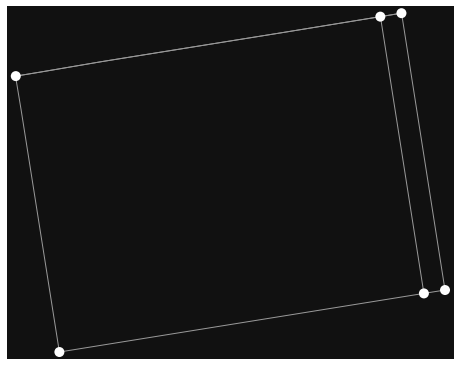

In [3]:
# define a point at the corner of California St and Mason St in SF
location_point = (37.791427, -122.410018)

# create network from point, inside bounding box of N, S, E, W each 100m from point
MDG = ox.graph_from_point(location_point, dist=100, dist_type="bbox", network_type="drive")
fig, ax = ox.plot_graph(MDG, node_color="white", node_size=100)

## A) Graph pre-processing

In [4]:
MDG = nx.convert_node_labels_to_integers(MDG) # Use label to deal with node id 
MG = ox.utils_graph.get_undirected(MDG) # MultiDiGraph -> MultiGraph

**Position**: First you need to manipulate the node positions from the graph into a dictionary. This will allow you to recreate the graph using the same layout as the actual trail map. Y is negated to transform the Y-axis origin from the topleft to the bottomleft.

In [5]:
# Define node positions data structure (dict) for plotting
node_positions = {node[0]: (node[1]['x'], -node[1]['y']) for node in MG.nodes(data=True)}

# Preview of node_positions with a bit of hack (there is no head/slice method for dictionaries).
dict(list(node_positions.items())[0:10])

{0: (-122.4108302, -37.791838),
 1: (-122.4106394, -37.7908839),
 2: (-122.4090444, -37.7910866),
 3: (-122.409235, -37.7920436),
 4: (-122.4091426, -37.7920556),
 5: (-122.408952, -37.7910983)}

# II/ CPP

## CPP Step 1: Find Nodes of Odd Degree

In [6]:
# Calculate list of nodes with odd degree
nodes_odd_degree = [v for v, d in MG.degree() if d % 2 == 1]

# Preview
nodes_odd_degree

[2, 3]

In [7]:
# Counts
print('Number of nodes of odd degree: {}'.format(len(nodes_odd_degree)))
print('Number of total nodes: {}'.format(len(MG.nodes())))

Number of nodes of odd degree: 2
Number of total nodes: 6


## CPP Step 2: Find Min Distance Pairs

1. Compute all possible pairs of odd degree nodes.

2. Compute the shortest path between each node pair calculated in **1.**

3. Create a complete graph connecting every node pair in 1. with shortest path distance attributes calculated in **2.**

4. Compute a minimum weight matching of the graph calculated in **3.** (This boils down to determining how to pair the odd nodes such that the sum of the distance between the pairs is as small as possible).

5. Augment the original graph with the shortest paths between the node pairs calculated in **4.**

### Step 2.1: Compute Node Pairs/Couple

In [8]:
# Compute all pairs of odd nodes. in a list of tuples
odd_node_pairs = list(itertools.combinations(nodes_odd_degree, 2))

# Preview pairs of odd degree nodes
odd_node_pairs[0:10]

[(2, 3)]

In [9]:
print('Number of pairs: {}'.format(len(odd_node_pairs)))

Number of pairs: 1


### Step 2.2: Compute Shortest Paths between Node Pairs/Couple

In [10]:
def get_shortest_paths_distances(graph, pairs, edge_weight_name):
    """Compute shortest distance between each pair of nodes in a graph.  Return a dictionary keyed on node pairs (tuples)."""
    distances = {}
    for pair in pairs:
        distances[pair] = nx.dijkstra_path_length(graph, pair[0], pair[1], weight=edge_weight_name)
    return distances

In [11]:
weight = lambda u, v, d: d[0]['length']

# Compute shortest paths.  Return a dictionary with node pairs keys and a single value equal to shortest path distance.
odd_node_pairs_shortest_paths = get_shortest_paths_distances(MG, odd_node_pairs, weight)

# Preview with a bit of hack (there is no head/slice method for dictionaries).
dict(list(odd_node_pairs_shortest_paths.items())[0:10])

{(2, 3): 107.72500000000001}

### Step 2.3: Create Complete Graph

In [12]:
def create_complete_graph(pair_weights, flip_weights=True):
    """
    Create a completely connected graph using a list of vertex pairs and the shortest path distances between them
    Parameters:
        pair_weights: list[tuple] from the output of get_shortest_paths_distances
        flip_weights: Boolean. Should we negate the edge attribute in pair_weights?
    """
    g = nx.Graph()
    for k, v in pair_weights.items():
        wt_i = - v if flip_weights else v
        #BECAREFUL: pass argument by argument instead of dict.
        # DOCUMENTATION SUCK ASSES.
        g.add_edge(k[0], k[1], distance=v, weight=wt_i)
    return g

In [13]:
# Generate the complete graph
g_odd_complete = create_complete_graph(odd_node_pairs_shortest_paths, flip_weights=True)

# Counts
print('Number of nodes: {}'.format(len(g_odd_complete.nodes())))
print('Number of edges: {}'.format(len(g_odd_complete.edges())))

Number of nodes: 2
Number of edges: 1


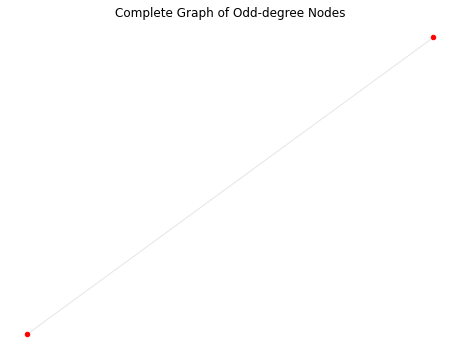

In [14]:
# Plot the complete graph of odd-degree nodes
plt.figure(figsize=(8, 6))
pos_random = nx.random_layout(g_odd_complete)
nx.draw_networkx_nodes(g_odd_complete, node_positions, node_size=20, node_color="red")
nx.draw_networkx_edges(g_odd_complete, node_positions, alpha=0.1)
plt.axis('off')
plt.title('Complete Graph of Odd-degree Nodes')
plt.show()

### Step 2.4: Compute Minimum Weight Matching

In [15]:
# Compute min weight matching.
# Note: max_weight_matching uses the 'weight' attribute by default as the attribute to maximize.
odd_matching = list(nx.algorithms.max_weight_matching(g_odd_complete, True))

print('Number of edges in matching: {}'.format(len(odd_matching)))

Number of edges in matching: 1


In [16]:
# Preview of matching
odd_matching

[(2, 3)]

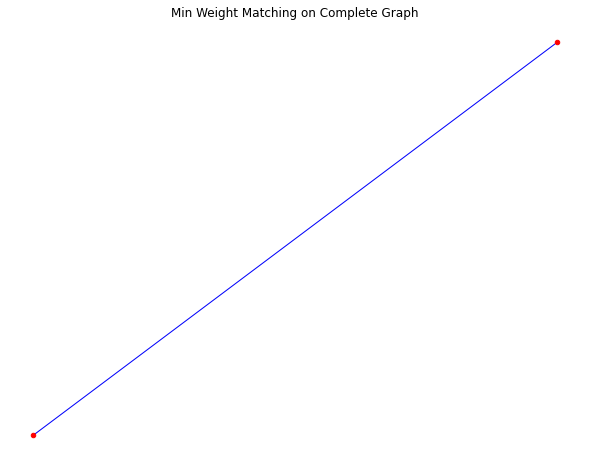

In [17]:
plt.figure(figsize=(8, 6))

# Plot the complete graph of odd-degree nodes
nx.draw(g_odd_complete, pos=node_positions, node_size=20, alpha=0.05)

# Create a new graph to overlay on g_odd_complete with just the edges from the min weight matching
g_odd_complete_min_edges = nx.Graph(odd_matching)
nx.draw(g_odd_complete_min_edges, pos=node_positions, node_size=20, edge_color='blue', node_color='red')

plt.title('Min Weight Matching on Complete Graph')
plt.show()

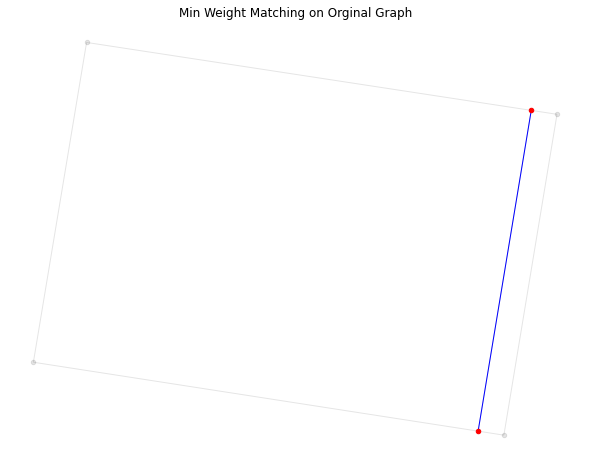

In [18]:
plt.figure(figsize=(8, 6))

# Plot the original trail map graph
nx.draw(MG, pos=node_positions, node_size=20, alpha=0.1, node_color='black')

# Plot graph to overlay with just the edges from the min weight matching
nx.draw(g_odd_complete_min_edges, pos=node_positions, node_size=20, alpha=1, node_color='red', edge_color='blue')

plt.title('Min Weight Matching on Orginal Graph')
plt.show()

### Step 2.5: Augment the Original Graph

In [19]:
def add_augmenting_path_to_graph(graph, min_weight_pairs):
    """
    Add the min weight matching edges to the original graph
    Parameters:
        graph: NetworkX graph (original graph from trailmap)
        min_weight_pairs: list[tuples] of node pairs from min weight matching
    Returns:
        augmented NetworkX graph
    """

    # We need to make the augmented graph a MultiGraph so we can add parallel edges
    graph_aug = nx.MultiGraph(graph.copy())
    for pair in min_weight_pairs:
        graph_aug.add_edge(pair[0],
                           pair[1],
                           **{'length': nx.dijkstra_path_length(graph, pair[0], pair[1], weight="length"),
                                      'trail': 'augmented'}
                          )
    return graph_aug

In [20]:
# Create augmented graph: add the min weight matching edges to g
g_aug = add_augmenting_path_to_graph(MG, odd_matching)

# Counts
print('Number of edges in original graph: {}'.format(len(MG.edges())))
print('Number of edges in augmented graph: {}'.format(len(g_aug.edges())))

Number of edges in original graph: 7
Number of edges in augmented graph: 8


In [21]:
d = {}
for e in dict(g_aug.degree()).values():
    if e not in d:
        d[e] = 1
    else:
        d[e] += 1
print(d)

{2: 4, 4: 2}


In [22]:
for i, e in enumerate(g_aug.edges(data=True)):
    if i < 5:
        print(e)
        print('-----')

(0, 1, {'osmid': 27166466, 'oneway': True, 'name': 'Mason Street', 'highway': 'residential', 'length': 107.41299999999998, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f2aab979828>, 'from': 0, 'to': 1})
-----
(0, 3, {'osmid': 674757876, 'name': 'California Street', 'highway': 'tertiary', 'oneway': False, 'length': 142.02499999999998, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f2aabafbb70>, 'from': 3, 'to': 0})
-----
(1, 2, {'osmid': 502795940, 'oneway': True, 'lanes': '2', 'name': 'Pine Street', 'highway': 'secondary', 'maxspeed': '30 mph', 'length': 141.957, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f2aabafba20>, 'from': 2, 'to': 1})
-----
(2, 3, {'osmid': 674757881, 'oneway': True, 'name': 'Powell Street', 'highway': 'tertiary', 'maxspeed': '25 mph', 'length': 107.72500000000001, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f2aabafbba8>, 'from': 3, 'to': 2})
-----
(2, 3, {'length': 107.72500000000001

## CPP Step 3: Compute Eulerian Circuit

If the graph is not eulerian, augmented with the edges we found during the min weight matching.

In [23]:
def create_eulerian_circuit(graph_augmented, graph_original, starting_node=None):
    """Create the eulerian path using only edges from the original graph."""
    euler_circuit = []
    naive_circuit = list(nx.eulerian_circuit(graph_augmented, source=starting_node))
    
    for edge in naive_circuit:
        edge_data = graph_augmented.get_edge_data(edge[0], edge[1])    
          
        if edge_data[0]['length'] != 'augmented':
            # If `edge` exists in original graph, grab the edge attributes and add to eulerian circuit.
            edge_att = graph_original[edge[0]][edge[1]]
            euler_circuit.append((edge[0], edge[1], edge_att))
        else:
            aug_path = nx.shortest_path(graph_original, edge[0], edge[1], weight='length')
            aug_path_pairs = list(zip(aug_path[:-1], aug_path[1:]))

            print('Filling in edges for augmented edge: {}'.format(edge))
            print('Augmenting path: {}'.format(' => '.join(aug_path)))
            print('Augmenting path pairs: {}\n'.format(aug_path_pairs))

            # If `edge` does not exist in original graph, find the shortest path between its nodes and
            #  add the edge attributes for each link in the shortest path.
            for edge_aug in aug_path_pairs:
                edge_aug_att = graph_original[edge_aug[0]][edge_aug[1]]
                euler_circuit.append((edge_aug[0], edge_aug[1], edge_aug_att))

    return euler_circuit

In [24]:
# Create the Eulerian circuit
euler_circuit = create_eulerian_circuit(g_aug, MG, 0)

In [25]:
print('Length of Eulerian circuit: {}'.format(len(euler_circuit)))

Length of Eulerian circuit: 8


### CPP Solution

In [26]:
for i, edge in enumerate(euler_circuit[0:20]):
    print(i, edge)

0 (0, 3, AtlasView({0: {'osmid': 674757876, 'name': 'California Street', 'highway': 'tertiary', 'oneway': False, 'length': 142.02499999999998, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f2aabafbb70>, 'from': 3, 'to': 0}}))
1 (3, 4, AtlasView({0: {'osmid': 100400946, 'name': 'California Street', 'highway': 'tertiary', 'oneway': False, 'length': 8.228, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f2aabafbc18>, 'from': 4, 'to': 3}}))
2 (4, 5, AtlasView({0: {'osmid': 674757885, 'oneway': True, 'name': 'Powell Street', 'highway': 'tertiary', 'maxspeed': '25 mph', 'length': 107.75699999999999, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f2aabafbc88>, 'from': 5, 'to': 4}}))
3 (5, 2, AtlasView({0: {'osmid': 674757877, 'oneway': True, 'lanes': '2', 'name': 'Pine Street', 'highway': 'secondary', 'maxspeed': '30 mph', 'length': 8.222999999999999, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f2aabafbcf8>, 'from': 5,

## Stats

In [27]:
# Computing some stats
total_mileage_of_circuit = sum([edge[2][0]['length'] for edge in euler_circuit])
total_mileage_on_orig_trail_map = sum(nx.get_edge_attributes(MG, 'length').values())
_vcn = pd.value_counts(pd.value_counts([(e[0]) for e in euler_circuit]), sort=False)
node_visits = pd.DataFrame({'n_visits': _vcn.index, 'n_nodes': _vcn.values})
_vce = pd.value_counts(pd.value_counts([sorted(e)[0] + sorted(e)[1] for e in nx.MultiDiGraph(euler_circuit).edges()]))
edge_visits = pd.DataFrame({'n_visits': _vce.index, 'n_edges': _vce.values})

# Printing stats
print('Mileage of circuit: {0:.2f}'.format(total_mileage_of_circuit))
print('Mileage on original trail map: {0:.2f}'.format(total_mileage_on_orig_trail_map))
print('Mileage retracing edges: {0:.2f}'.format(total_mileage_of_circuit-total_mileage_on_orig_trail_map))
print('Percent of mileage retraced: {0:.2f}%\n'.format((1-total_mileage_of_circuit/total_mileage_on_orig_trail_map)*-100))

print('Number of edges in circuit: {}'.format(len(euler_circuit)))
print('Number of edges in original graph: {}'.format(len(MG.edges())))
print('Number of nodes in original graph: {}\n'.format(len(MG.nodes())))

print('Number of edges traversed more than once: {}\n'.format(len(euler_circuit)-len(MG.edges())))  

print('Number of times visiting each node:')
print(node_visits.to_string(index=False))

print('\nNumber of times visiting each edge:')
print(edge_visits.to_string(index=False))

Mileage of circuit: 731.05
Mileage on original trail map: 623.33
Mileage retracing edges: 107.73
Percent of mileage retraced: 17.28%

Number of edges in circuit: 8
Number of edges in original graph: 7
Number of nodes in original graph: 6

Number of edges traversed more than once: 1

Number of times visiting each node:
 n_visits  n_nodes
        1        4
        2        2

Number of times visiting each edge:
 n_visits  n_edges
        2        3
        1        2


# IV/ Visualize CPP Solution

In [28]:
def create_cpp_edgelist(euler_circuit):
    """
    Create the edgelist without parallel edge for the visualization
    Combine duplicate edges and keep track of their sequence and # of walks
    Parameters:
        euler_circuit: list[tuple] from create_eulerian_circuit
    """
    cpp_edgelist = {}

    for i, e in enumerate(euler_circuit):
        edge = frozenset([e[0], e[1]])

        if edge in cpp_edgelist:
            cpp_edgelist[edge][2][0]['sequence'] += ', ' + str(i)
            cpp_edgelist[edge][2][0]['visits'] += 1

        else:
            cpp_edgelist[edge] = e
            cpp_edgelist[edge][2][0]['sequence'] = str(i)
            cpp_edgelist[edge][2][0]['visits'] = 1

    return list(cpp_edgelist.values())

In [29]:
cpp_edgelist = create_cpp_edgelist(euler_circuit)

In [30]:
print('Number of edges in CPP edge list: {}'.format(len(cpp_edgelist)))

Number of edges in CPP edge list: 7


In [31]:
cpp_edgelist[0:3]

[(0,
  3,
  AtlasView({0: {'osmid': 674757876, 'name': 'California Street', 'highway': 'tertiary', 'oneway': False, 'length': 142.02499999999998, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f2aabafbb70>, 'from': 3, 'to': 0, 'sequence': '0', 'visits': 1}})),
 (3,
  4,
  AtlasView({0: {'osmid': 100400946, 'name': 'California Street', 'highway': 'tertiary', 'oneway': False, 'length': 8.228, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f2aabafbc18>, 'from': 4, 'to': 3, 'sequence': '1', 'visits': 1}})),
 (4,
  5,
  AtlasView({0: {'osmid': 674757885, 'oneway': True, 'name': 'Powell Street', 'highway': 'tertiary', 'maxspeed': '25 mph', 'length': 107.75699999999999, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f2aabafbc88>, 'from': 5, 'to': 4, 'sequence': '2', 'visits': 1}}))]

In [32]:
# Create CPP solution graph
g_cpp = nx.Graph(cpp_edgelist)

## Visualization 1: Retracing Steps

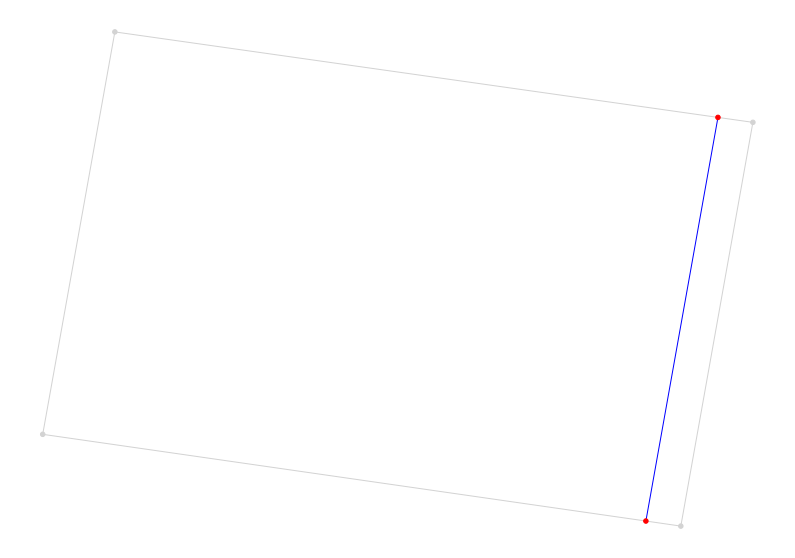

In [33]:
plt.figure(figsize=(14, 10))

visit_colors = {1:'lightgray', 2:'blue'}
edge_colors = [visit_colors[e[2][0]['visits']] for e in g_cpp.edges(data=True)]
node_colors = ['red'  if node in nodes_odd_degree else 'lightgray' for node in g_cpp.nodes()]

nx.draw_networkx(g_cpp, pos=node_positions, node_size=20, node_color=node_colors, edge_color=edge_colors, with_labels=False)
plt.axis('off')
plt.show()

## Visualization 3: Movie

In [40]:
visit_colors = {1:'black', 2:'red'}
edge_cnter = {}
g_i_edge_colors = []
for i, e in enumerate(euler_circuit, start=1):

    edge = frozenset([e[0], e[1]])
    if edge in edge_cnter:
        edge_cnter[edge] += 1
    else:
        edge_cnter[edge] = 1

    # Full graph (faded in background)
    nx.draw_networkx(g_cpp, pos=node_positions, node_size=6, node_color='gray', with_labels=False, alpha=0.07)

    # Edges walked as of iteration i
    euler_circuit_i = copy.deepcopy(euler_circuit[0:i])
    for i in range(len(euler_circuit_i)):
        edge_i = frozenset([euler_circuit_i[i][0], euler_circuit_i[i][1]])
        euler_circuit_i[i][2][0]['visits_i'] = edge_cnter[edge_i]
    g_i = nx.Graph(euler_circuit_i)
    g_i_edge_colors = [visit_colors[e[2][0]['visits_i']] for e in g_i.edges(data=True)]

    #nx.draw_networkx_nodes(g_i, pos=node_positions, node_size=6, alpha=0.6, node_color='lightgray', with_labels=False, linewidths=0.1)
    nx.draw_networkx_nodes(g_i, pos=node_positions, node_size=6, alpha=0.6, node_color='lightgray', linewidths=0.1)
    nx.draw_networkx_edges(g_i, pos=node_positions, edge_color=g_i_edge_colors, alpha=0.8)

    plt.axis('off')
    plt.savefig('fig/png/img{}.png'.format(i), dpi=120, bbox_inches='tight')
    plt.close()

In [41]:
import glob
import numpy as np
import imageio
import os

def make_circuit_video(image_path, movie_filename, fps=5):
    # sorting filenames in order
    filenames = glob.glob(image_path + 'img*.png')
    filenames_sort_indices = np.argsort([int(os.path.basename(filename).split('.')[0][3:]) for filename in filenames])
    filenames = [filenames[i] for i in filenames_sort_indices]

    # make movie
    with imageio.get_writer(movie_filename, mode='I', fps=fps) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

make_circuit_video('fig/png/', 'fig/gif/cpp_route_animation.gif', fps=3)